<a href="https://colab.research.google.com/github/NicKomarov/neural_net_laba1/blob/main/Neural_net_laba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install purifytext tensorflow

In [ ]:
import os
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from purifytext import clean_text
from sklearn.model_selection import train_test_split
from keras import layers, models
from sklearn.metrics import classification_report

In [ ]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

files = os.listdir(path)
for file in files:
    print(file)

IMDB Dataset.csv


In [ ]:
df = pd.read_csv(os.path.join(path, "IMDB Dataset.csv"))
print(df)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [ ]:
df['sentiment'].value_counts().reset_index()

,sentiment,count
0,positive,25000
1,negative,25000


In [ ]:
df_clean=clean_text(dataframe=df, column_name='review', stemming=True, lemmatizing=False)

df_clean['sentiment'] = df_clean['sentiment'].map({'positive': 1, 'negative': 0})
df_clean.head()


=== Cleaning Process ===

⬇️ Removing HTML Tags ⬇️


/usr/local/lib/python3.10/dist-packages/purifytext/text_preprocessing.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")



⬇️ Lowercasing Text ⬇️

⬇️ Removing URLs ⬇️

⬇️ Removing Emojis ⬇️

⬇️ Removing Punctuation ⬇️

⬇️ Removing Special Characters ⬇️

⬇️ Removing Numbers ⬇️

⬇️ Removing Whitespace ⬇️

⬇️ Expanding Contractions ⬇️

⬇️ Removing Stopwords ⬇️

⬇️ Stemming Words ⬇️

=== Cleaning Completed ===



,review,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


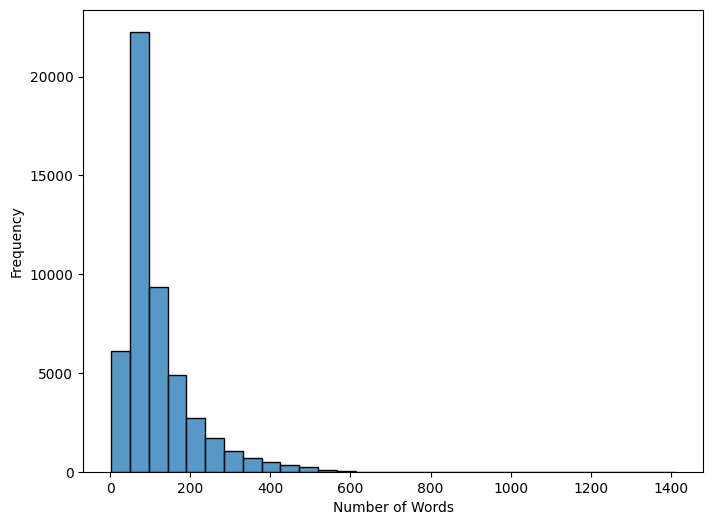

In [ ]:
max_words = df_clean['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.histplot(max_words, bins=30)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
max_len = 300

X = df_clean['review'].values
y = df_clean['sentiment'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(40000, 10000, 40000, 10000)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<nothing>")
tokenizer.fit_on_texts(X)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,padding = 'pre', maxlen = max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,padding = 'pre', maxlen = max_len)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim = 128, input_length = max_len))
model.add(layers.SimpleRNN(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.build(input_shape = (None, max_len))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 300, 128)            │      22,344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_10 (SimpleRNN)            │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,377,217 (85.36 MB)

 Trainable params: 22,377,217 (85.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 64,
                    validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 247s 492ms/step - accuracy: 0.6649 - loss: 0.5880 - val_accuracy: 0.8313 - val_loss: 0.3984
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 491ms/step - accuracy: 0.8987 - loss: 0.2659 - val_accuracy: 0.8636 - val_loss: 0.3366
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 258s 483ms/step - accuracy: 0.9351 - loss: 0.1913 - val_accuracy: 0.8577 - val_loss: 0.3643
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 480ms/step - accuracy: 0.9730 - loss: 0.0772 - val_accuracy: 0.8546 - val_loss: 0.4666
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 479ms/step - accuracy: 0.9878 - loss: 0.0363 - val_accuracy: 0.8359 - val_loss: 0.4922
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 261s 478ms/step - accuracy: 0.9901 - loss: 0.0312 - val_accuracy: 0.7085 - val_loss: 0.5984
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 262s 478ms/step - accuracy: 0.8798 - loss: 0.2899 - val_accuracy: 0.8296 - val_loss: 0.4619


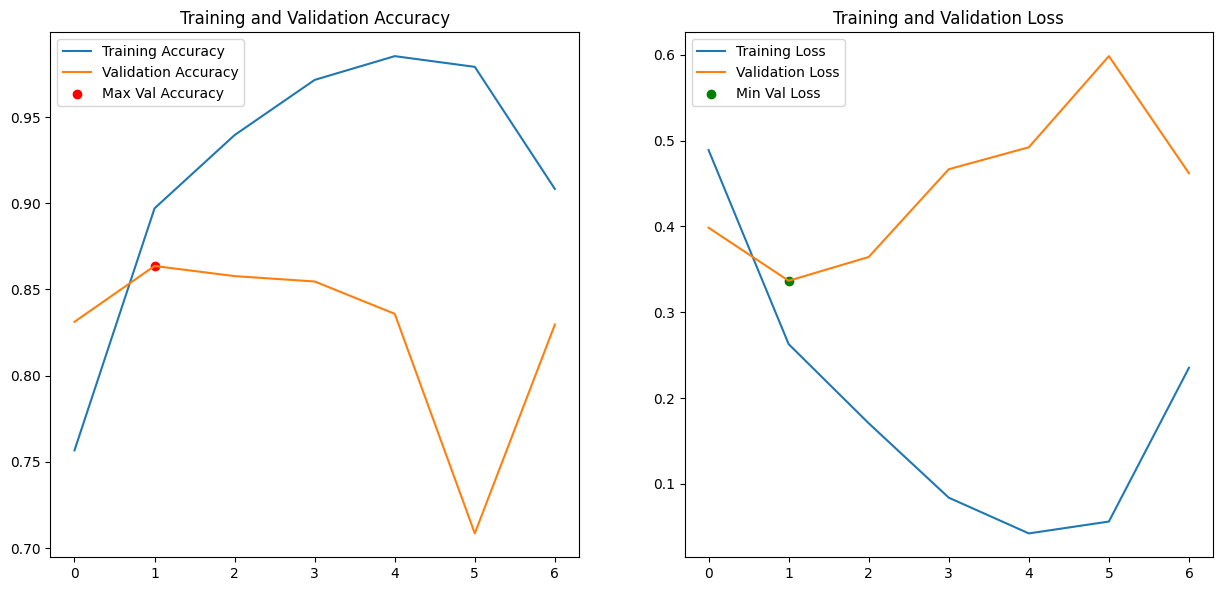

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 15))

# Plotting Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Marking the highest validation accuracy point
max_val_acc_index = val_acc.index(max(val_acc))
plt.scatter(max_val_acc_index, max(val_acc), color='red', marker='o', label='Max Val Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Marking the lowest validation loss point
min_val_loss_index = val_loss.index(min(val_loss))
plt.scatter(min_val_loss_index, min(val_loss), color='green', marker='o', label='Min Val Loss')
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step


Text(95.72222222222221, 0.5, 'Actual')

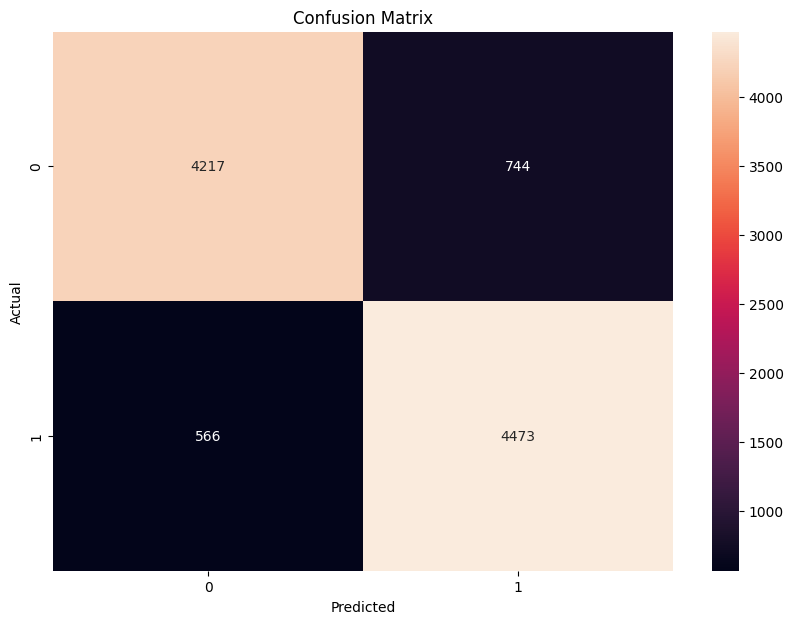

In [ ]:
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred_rounded))

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      4961
           1       0.86      0.89      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

